In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd

# Joining Crash Data to Node Graph

The goal here is to take each crash for which we have a latitude and a longitude and associate it with a specific node from the graph subset we're using.

If any crash event does not have a node that is associated with it, then we drop the crash.

In [2]:
# We load the graph whose nodes we intend to use:
G = ox.graph_from_address("420 East 73rd Street, New York, New York 10021", network_type="bike")

/usr/local/Caskroom/miniconda/base/envs/spokenv/lib/python3.8/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/Caskroom/miniconda/base/envs/spokenv/lib/python3.8/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/Caskroom/miniconda/base/envs/spokenv/lib/python3.8/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


In [3]:
crash_df = pd.read_csv('../../data/crash_data_normalized.csv')

/usr/local/Caskroom/miniconda/base/envs/spokenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
from tqdm.notebook import tqdm
# This is the distance from a crash to its nearest node beyond which we assume
# that the crash occurred outside of our graph and isn't really matched to that node.
THRESHOLD_DIST_M = 100
nearest_nodes = pd.DataFrame(columns=['NODE_ID', 'NODE_DIST_FROM_CRASH_M', 'NODE_LATITUDE', 'NODE_LONGITUDE'])

for i, crash in tqdm(crash_df.iterrows(), total=crash_df.shape[0]):
    nn_id, dist = ox.distance.nearest_nodes(G, crash.LONGITUDE, crash.LATITUDE, return_dist=True)
    if dist > THRESHOLD_DIST_M:
        continue
    nn = G.nodes[nn_id]
    nearest_nodes.loc[i] = {
        'NODE_ID': nn_id,
        'NODE_DIST_FROM_CRASH_M': dist,
        'NODE_LATITUDE': nn['y'],
        'NODE_LONGITUDE': nn['x'],
    }
    
nearest_nodes

  0%|          | 0/125261 [00:00<?, ?it/s]

,NODE_ID,NODE_DIST_FROM_CRASH_M,NODE_LATITUDE,NODE_LONGITUDE
163,42447076,1.914519,40.768476,-73.963601
203,42428010,1.160962,40.767541,-73.953249
237,42439563,0.972515,40.770119,-73.957398
272,42439561,1.315988,40.771053,-73.959651
353,42456049,1.798715,40.761488,-73.960589
...,...,...,...,...
125102,42456060,0.492336,40.772341,-73.952682
125152,42450015,0.753201,40.774289,-73.957290
125176,42438805,1.786375,40.768477,-73.955483
125208,42456041,85.591821,40.758981,-73.962432


In [5]:
# Append the columns from the node df, including only the rows that have an associated node
crash_df_with_nodes = pd.concat((crash_df, nearest_nodes), join='inner', axis=1)

crash_df_with_nodes

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,...,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,NODE_ID,NODE_DIST_FROM_CRASH_M,NODE_LATITUDE,NODE_LONGITUDE
163,1809,04/20/2021,9:22,MANHATTAN,10021.0,40.768486,-73.963620,"(40.768486, -73.96362)",EAST 69 STREET,LEXINGTON AVENUE,...,4408868,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,42447076,1.914519,40.768476,-73.963601
203,2263,04/22/2021,19:16,MANHATTAN,10021.0,40.767532,-73.953255,"(40.767532, -73.953255)",YORK AVENUE,EAST 73 STREET,...,4409716,Taxi,E-Bike,NaN,NaN,NaN,42428010,1.160962,40.767541,-73.953249
237,2575,04/21/2021,1:05,MANHATTAN,10021.0,40.770120,-73.957410,"(40.77012, -73.95741)",EAST 74 STREET,2 AVENUE,...,4409057,NaN,NaN,NaN,NaN,NaN,42439563,0.972515,40.770119,-73.957398
272,2797,04/23/2021,14:12,MANHATTAN,10021.0,40.771065,-73.959650,"(40.771065, -73.95965)",3 AVENUE,EAST 74 STREET,...,4410501,Sedan,Bike,NaN,NaN,NaN,42439561,1.315988,40.771053,-73.959651
353,3568,07/19/2021,0:20,NaN,NaN,40.761486,-73.960610,"(40.761486, -73.96061)",1 AVENUE,NaN,...,4438688,Sedan,NaN,NaN,NaN,NaN,42456049,1.798715,40.761488,-73.960589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125102,1834635,07/06/2012,21:20,MANHATTAN,10075,40.772344,-73.952686,"(40.7723438, -73.9526861)",EAST 79 STREET,1 AVENUE,...,44972,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN,42456060,0.492336,40.772341,-73.952682
125152,1835488,07/06/2012,9:36,MANHATTAN,10075.0,40.774283,-73.957295,"(40.7742834, -73.9572953)",3 AVENUE,EAST 79 STREET,...,44967,TAXI,BICYCLE,NaN,NaN,NaN,42450015,0.753201,40.774289,-73.957290
125176,1835914,07/04/2012,14:00,MANHATTAN,10021.0,40.768486,-73.955501,"(40.7684858, -73.9555012)",EAST 73 STREET,1 AVENUE,...,44953,PASSENGER VEHICLE,BICYCLE,NaN,NaN,NaN,42438805,1.786375,40.768477,-73.955483
125208,1836365,07/06/2012,15:45,MANHATTAN,10022.0,40.758308,-73.962926,"(40.7583082, -73.9629257)",EAST 57 STREET,1 AVENUE,...,32095,SMALL COM VEH(4 TIRES),NaN,NaN,NaN,NaN,42456041,85.591821,40.758981,-73.962432


In [6]:
# Let's try displaying the number of crashes per intersection now.

# First group by the NODE_ID and count the values
crash_counts_by_node = crash_df_with_nodes.groupby('NODE_ID').size()

# Then we want to make this fully populated with respect to the set of nodes in the graph
def saturate_nodes(G, s):
    for node_id in G.nodes:
        if node_id in s.index:
            continue
        else:
            s.loc[node_id] = 0
    return s
crash_counts_by_node = saturate_nodes(G, crash_counts_by_node)

crash_counts_by_node.sort_values()

NODE_ID
9100506061     0
5542680310     0
5463840962     0
5463840961     0
5401365957     0
              ..
42424089      42
42442961      43
42456041      48
6177439759    52
42432861      59
Length: 360, dtype: int64

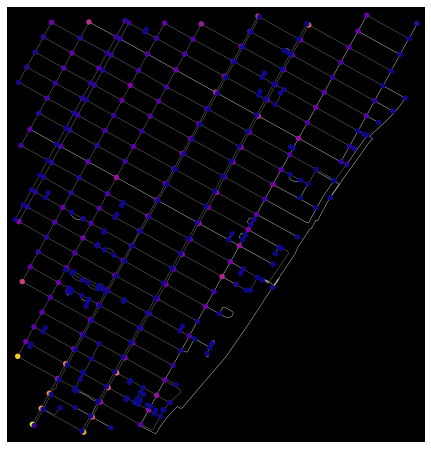

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [7]:
# Now we set the node attributes to be this crash count
nx.set_node_attributes(G, dict(crash_counts_by_node), "n_crashes")
# Now we map these to colors
nc = ox.plot.get_node_colors_by_attr(G, "n_crashes", cmap="plasma")
# Now we plot the graph with the colors
ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
)

It looks like we're getting a lot of crashes clumped into the edges here. Let's display the mean distance from the crash to the nodes on this map instead to get an idea of the edge effects here.

In [8]:
saturate_nodes(G, crash_df_with_nodes.groupby('NODE_ID').mean()['NODE_DIST_FROM_CRASH_M'])

NODE_ID
42424089       4.106116
42424672      54.418973
42427965       0.597504
42427968       1.316616
42427970       4.728773
                ...    
8996371855     0.000000
8996988342     0.000000
9001600168     0.000000
9030177782     0.000000
9100506061     0.000000
Name: NODE_DIST_FROM_CRASH_M, Length: 360, dtype: float64

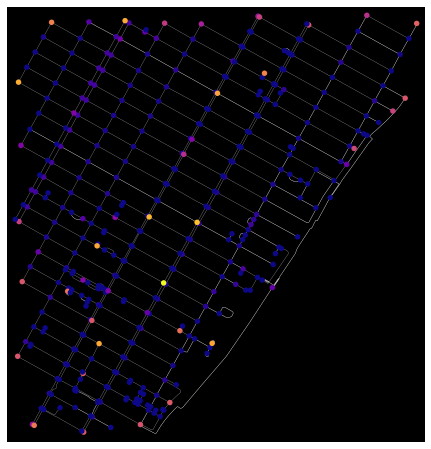

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [9]:
nx.set_node_attributes(G, dict(saturate_nodes(G, crash_df_with_nodes.groupby('NODE_ID').mean()['NODE_DIST_FROM_CRASH_M'])), 'dist_from_crash')
nc = ox.plot.get_node_colors_by_attr(G, 'dist_from_crash', cmap='plasma')
ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
)

From the above, it looks like although the edges are definitely picking up some crashes that would probably be better associated with nodes that are being clipped from the map, they are not altogether dramatically worse in this regard than many of the nodes centered in the graph. We'll keep it as-is.

Let's write the data we have to a CSV:

In [10]:
crash_df_with_nodes.to_csv('../../data/crash_data_normalized_with_node_graph.csv')